### Dedupe needs more setup therefore a notebook so i can handle it step by Step


In [1]:
import rdflib

ttl_path = "data/healthcare_graph_original_v2.ttl"

def extract_dedupe_fields_from_ttl(ttl_path):
    g = rdflib.Graph()
    g.parse("data/healthcare_graph_original_v2.ttl")
    
    # Map: {entity_type: set([literal_predicate_names])}
    type_predicate_map = {}
    
    for s in set(g.subjects()):
        # Get type
        types = [str(o) for o in g.objects(s, rdflib.RDF.type)]
        if not types:
            continue
        type_ = types[0].split("/")[-1]  # Or use more sophisticated logic if needed
        
        # Gather literal predicates
        predicates = set()
        for p, o in g.predicate_objects(s):
            if isinstance(o, rdflib.Literal):
                pred_name = p.split("/")[-1] if "/" in str(p) else str(p)
                predicates.add(pred_name)
        if type_ not in type_predicate_map:
            type_predicate_map[type_] = set()
        type_predicate_map[type_].update(predicates)
    
    # Build dedupe.io field definitions per entity type
    dedupe_fields = {}
    for type_, preds in type_predicate_map.items():
        dedupe_fields[type_] = [
            {'field': pred, 'type': 'String'} for pred in preds if pred.lower() != "identifier"
]

    return dedupe_fields

fields_per_type = extract_dedupe_fields_from_ttl("data/healthcare_graph_original_v2.ttl")
for entity_type, fields in fields_per_type.items():
    print(f"Entity type: {entity_type}")
    print(fields)
    print()

Entity type: PostalAddress
[{'field': 'streetAddress', 'type': 'String'}, {'field': 'postalCode', 'type': 'String'}, {'field': 'addressCountry', 'type': 'String'}, {'field': 'addressLocality', 'type': 'String'}]

Entity type: ContactPoint
[{'field': 'telephone', 'type': 'String'}, {'field': 'availableLanguage', 'type': 'String'}, {'field': 'contactType', 'type': 'String'}, {'field': 'faxNumber', 'type': 'String'}, {'field': 'email', 'type': 'String'}]

Entity type: Person
[{'field': 'jobTitle', 'type': 'String'}, {'field': 'gender', 'type': 'String'}, {'field': 'name', 'type': 'String'}, {'field': 'birthDate', 'type': 'String'}, {'field': 'knowsLanguage', 'type': 'String'}, {'field': 'email', 'type': 'String'}]

Entity type: Department
[{'field': 'name', 'type': 'String'}]

Entity type: MedicalOrganization
[{'field': 'name', 'type': 'String'}]



In [2]:
from modular_methods.graphToText_utils import kg_to_dedupe_dict
g = rdflib.Graph()
g1 = rdflib.Graph()
g2 = rdflib.Graph()
g3 = rdflib.Graph()
g4 = rdflib.Graph()
g.parse("data/healthcare_graph_original_v2.ttl")
g1.parse("data/healthcare_graph_replaced_low.ttl")# sample of the first 15 HCO's
g2.parse("data/healthcare_graph_train.ttl")# sample of the other 35 HCO's 
g3.parse("data/healthcare_graph_replaced_medium.ttl")# sample of the other 35 HCO's
g4.parse("data/healthcare_graph_replaced_high.ttl")# sample of the other
dict_main = kg_to_dedupe_dict(g)
dict_low = kg_to_dedupe_dict(g1)
train_dict = kg_to_dedupe_dict(g2)
dict_medium = kg_to_dedupe_dict(g3)
dict_high = kg_to_dedupe_dict(g4)   

In [3]:
import json
with open("data/dedupe_data/dict_main.json", "w") as f:
    json.dump(dict_main, f, indent=2)
with open("data/dedupe_data/dict_low.json", "w") as f:
    json.dump(dict_low, f, indent=2)
with open("data/dedupe_data/dict_medium.json", "w") as f:
    json.dump(dict_medium, f, indent=2)
with open("data/dedupe_data/dict_high.json", "w") as f:
    json.dump(dict_high, f, indent=2)
with open("data/dedupe_data/train_dict.json", "w") as f:
    json.dump(train_dict, f, indent=2)

## Ground truth for test data

In [27]:
import pandas as pd 
golden_standard = pd.read_csv('data/test_golden_standard_low_updated.csv')

# Replace entity types
golden_standard['entity_type'] = golden_standard['entity_type'].replace({
    'HealthcareOrganization': 'HealthcareOrg',
    'ServiceDepartment': 'ServiceDept'
})

golden_standard_subset = golden_standard[['original_id', 'duplicate_id', 'entity_type']]
golden_standard_subset_var = golden_standard[['original_id', 'duplicate_id', 'entity_type','variation_type']]


ground_truth_test = {}

# Mapping to Person for both Person and HealthcarePersonnel
for entity in golden_standard_subset_var['entity_type'].unique():
    df_filtered = golden_standard_subset_var[golden_standard_subset_var['entity_type'] == entity]
    entity_for_uri = "Person" if entity in ["Person", "HealthcarePersonnel"] else entity
    # Use 'Person' as the key for both types
    key = "Person" if entity in ["Person", "HealthcarePersonnel"] else entity
    if key not in ground_truth_test:
        ground_truth_test[key] = []
    ground_truth_test[key].extend([
        (f"http://example.org/{entity_for_uri}/{row['original_id']}", 
         f"http://example.org/{entity_for_uri}/{row['duplicate_id']}")
        for _, row in df_filtered.iterrows()
    ])

test_GT_Person = ground_truth_test['Person']
test_GT_HealthcareOrg = ground_truth_test['HealthcareOrg']
test_GT_ServiceDept = ground_truth_test['ServiceDept']
test_GT_Address = ground_truth_test['Address']
test_GT_ContactPoint = ground_truth_test['ContactPoint']

In [5]:
test_GT_HealthcareOrg

[('http://example.org/HealthcareOrg/037d9752-48f3-431c-8fb7-c3bb4408c04c',
  'http://example.org/HealthcareOrg/3d598812-bdbc-4373-aca8-5d9ab013042c'),
 ('http://example.org/HealthcareOrg/c7405255-25cf-41c4-9c89-929692b035e0',
  'http://example.org/HealthcareOrg/2d7412d5-c558-46f8-9a6f-7afd5b436758'),
 ('http://example.org/HealthcareOrg/30d6863f-11c2-42d8-8126-77895c6be596',
  'http://example.org/HealthcareOrg/4d655899-f2d2-4f8b-ac02-448ecbcb49db'),
 ('http://example.org/HealthcareOrg/06d2ed7c-e6ac-4d8a-8160-ff927c7550f2',
  'http://example.org/HealthcareOrg/f365566d-f533-4ae8-93be-2743d3aab509'),
 ('http://example.org/HealthcareOrg/92d6ff73-5b3a-4595-8458-92c14e0e15d3',
  'http://example.org/HealthcareOrg/2a4c7e62-dba3-4a63-91bf-2cad324cc811'),
 ('http://example.org/HealthcareOrg/52ebdac5-a145-4899-a1f8-c1569e0df45b',
  'http://example.org/HealthcareOrg/43e9d631-b954-478c-9552-dd0a8da6b31d'),
 ('http://example.org/HealthcareOrg/71a8c9c6-0f6a-475b-b55b-2e5ca6ed0ac0',
  'http://example.o

### Perform the manual labelling on train data NOT on test data

In [6]:


golden_standard = pd.read_csv('data/train_golden_standard_duplicates_updated.csv')

# Replace entity types
golden_standard['entity_type'] = golden_standard['entity_type'].replace({
    'HealthcareOrganization': 'HealthcareOrg',
    'ServiceDepartment': 'ServiceDept'
})

golden_standard_subset = golden_standard[['original_id', 'duplicate_id', 'entity_type']]
golden_standard_subset_var = golden_standard[['original_id', 'duplicate_id', 'entity_type','variation_type']]


ground_truth_train = {}

# Mapping to Person for both Person and HealthcarePersonnel
for entity in golden_standard_subset_var['entity_type'].unique():
    df_filtered = golden_standard_subset_var[golden_standard_subset_var['entity_type'] == entity]
    entity_for_uri = "Person" if entity in ["Person", "HealthcarePersonnel"] else entity
    # Use 'Person' as the key for both types
    key = "Person" if entity in ["Person", "HealthcarePersonnel"] else entity
    if key not in ground_truth_train:
        ground_truth_train[key] = []
    ground_truth_train[key].extend([
        (f"http://example.org/{entity_for_uri}/{row['original_id']}", 
         f"http://example.org/{entity_for_uri}/{row['duplicate_id']}")
        for _, row in df_filtered.iterrows()
    ])

# Instead of taking first 50 Person pairs, select 7 per variation type
person_variations = golden_standard_subset_var[
    (golden_standard_subset_var['entity_type'] == 'Person') | 
    (golden_standard_subset_var['entity_type'] == 'HealthcarePersonnel')
]

person_variations

,original_id,duplicate_id,entity_type,variation_type
512,f725b007-e192-499f-8d89-17df03e645b9,fd9b6e79-0ea3-4c09-a58b-01e1e4dae834,Person,name_typo
513,4aa7a7fb-f399-480e-9451-80ee6a7d6b1c,fd715c26-3895-4dff-86c5-83ff68751bc6,Person,abbreviated_first_name
514,4aa7a7fb-f399-480e-9451-80ee6a7d6b1c,fd715c26-3895-4dff-86c5-83ff68751bc6,HealthcarePersonnel,email_typo
515,23984285-e82d-4545-8584-7c7b35672a2e,6a939e3d-9e7c-4b7f-9345-930009129a04,Person,date_format_variation
516,23984285-e82d-4545-8584-7c7b35672a2e,6a939e3d-9e7c-4b7f-9345-930009129a04,HealthcarePersonnel,email_typo
...,...,...,...,...
1967,aba55918-992e-4367-aa5f-0dc9ad6d7da5,b5fb00af-6123-4ce3-9fa0-5531c0ad9164,HealthcarePersonnel,email_typo
1968,826c9f2f-e5ec-48b3-b1f3-6b6cc1cf07ee,b8b80f89-ece5-4a49-a5b2-fd36804375fd,HealthcarePersonnel,email_typo
1969,04a5b104-36fb-4c42-95f9-1f5052a2703d,5b56305b-42d8-4e43-b358-f5afd592d9e8,HealthcarePersonnel,email_typo
1970,67ddb936-3e0f-4a71-9f7c-4f1a1e94d967,96b2cf5d-58bf-49e7-95ec-8916422a9ea5,HealthcarePersonnel,email_typo


In [7]:
# Get 7 examples per variation type
GT_Person_by_variation = []
for variation_type in person_variations['variation_type'].unique():
    variation_pairs = person_variations[person_variations['variation_type'] == variation_type]
    
    # Take up to 7 pairs for this variation type
    selected_pairs = variation_pairs.head(20)
    
    for _, row in selected_pairs.iterrows():
        GT_Person_by_variation.append((
            f"http://example.org/Person/{row['original_id']}", 
            f"http://example.org/Person/{row['duplicate_id']}"
        ))

# Replace your existing GT_Person line with:
GT_Person = GT_Person_by_variation

print(f"Total Person pairs selected: {len(GT_Person)}")
print(f"Variation types: {person_variations['variation_type'].unique()}")

# Check distribution
for variation_type in person_variations['variation_type'].unique():
    count = len(person_variations[person_variations['variation_type'] == variation_type].head(20))
    print(f"{variation_type}: {count} pairs")



GT_HCO = ground_truth_train['HealthcareOrg'][:10] # print first 10 pairs


import random


def sample_distinct_pairs(golden_standard_subset, ground_truth_pairs, entity_type, n_neg=3):
    """Sample distinct pairs for dedupe.io (negatives), avoiding ground truth."""
    filtered = golden_standard_subset[golden_standard_subset['entity_type'] == entity_type]
    all_ids1 = filtered['original_id'].unique()
    all_ids2 = filtered['duplicate_id'].unique()
    gt_set = set(ground_truth_pairs)
    distinct_pairs = set()
    attempts = 0
    max_attempts = len(gt_set) * n_neg * 10  # Prevent infinite loop
    
    while len(distinct_pairs) < len(gt_set) * n_neg and attempts < max_attempts:
        a, b = random.choice(all_ids1), random.choice(all_ids2)
        if (a, b) not in gt_set and (b, a) not in gt_set and (a, b) not in distinct_pairs:
            distinct_pairs.add((f"http://example.org/{entity_type}/{a}", f"http://example.org/{entity_type}/{b}"))
        attempts += 1
    return list(distinct_pairs)

entity_types = ['Address', 'Person', 'HealthcareOrg', 'ServiceDept', 'ContactPoint']
distinct_pairs = {}
for entity_type in entity_types:
    negatives = sample_distinct_pairs(
        golden_standard_subset, ground_truth_train[entity_type], entity_type, n_neg=3
    )
    distinct_pairs[entity_type] = negatives

DP_Ad = distinct_pairs['Address'][:20]   
DP_Person = distinct_pairs['Person'][:25]
DP_HCO = distinct_pairs['HealthcareOrg'][:10]
DP_SD = distinct_pairs['ServiceDept'][:15]
DP_CP = distinct_pairs['ContactPoint'][:20]



Total Person pairs selected: 120
Variation types: ['name_typo' 'abbreviated_first_name' 'email_typo' 'date_format_variation'
 'name_swap' 'language_expansion']
name_typo: 20 pairs
abbreviated_first_name: 20 pairs
email_typo: 20 pairs
date_format_variation: 20 pairs
name_swap: 20 pairs
language_expansion: 20 pairs


In [8]:
# Map of entity type to dedupe.io fields
ENTITY_FIELDS = {
    "Person": [
        {'field': 'knowsLanguage', 'type': 'String'},
        {'field': 'jobTitle', 'type': 'String'},
        {'field': 'name', 'type': 'String'},
        {'field': 'birthDate', 'type': 'String'},
        {'field': 'gender', 'type': 'String'},
        {'field': 'email', 'type': 'String'}
    ],
    "ContactPoint": [
        {'field': 'faxNumber', 'type': 'String'},
        {'field': 'availableLanguage', 'type': 'String'},
        {'field': 'telephone', 'type': 'String'},
        {'field': 'email', 'type': 'String'},
        {'field': 'contactType', 'type': 'String'}
    ],
    "Department": [
        {'field': 'name', 'type': 'String'}
    ],
    "PostalAddress": [
        {'field': 'addressLocality', 'type': 'String'},
        {'field': 'streetAddress', 'type': 'String'},
        {'field': 'postalCode', 'type': 'String'},
        {'field': 'addressCountry', 'type': 'String'}
    ],
    "MedicalOrganization": [
        {'field': 'name', 'type': 'String'}
    ]
}

import dedupe
import dedupe.variables

ENTITY_FIELDS_dedup= {"Person": [
        dedupe.variables.String("knowsLanguage"),
        dedupe.variables.String("jobTitle"),
        dedupe.variables.String("name"),
        dedupe.variables.String("birthDate"),
        dedupe.variables.String("gender"),
        dedupe.variables.String("email")
    ],
    "ContactPoint": [
        dedupe.variables.String("faxNumber"),
        dedupe.variables.String("availableLanguage"),
        dedupe.variables.String("telephone"),
        dedupe.variables.String("email"),
        dedupe.variables.String("contactType")
    ],
    "Department": [
        dedupe.variables.String("name")
    ],
    "PostalAddress": [
        dedupe.variables.String("addressLocality"),
        dedupe.variables.String("streetAddress"),
        dedupe.variables.String("postalCode"),
        dedupe.variables.String("addressCountry")
    ],
    "MedicalOrganization": [
        dedupe.variables.String("name")
    ]}



def filter_entity(d, entity_type):
    search_str = f"/{entity_type}/"
    return {k: v for k, v in d.items() if search_str in k}

person_dict1 = filter_entity(dict_main, "Person")
person_dict2 = filter_entity(dict_low, "Person")
train_person_dict1 = filter_entity(train_dict, "Person")


In [9]:
GT_Person

[('http://example.org/Person/f725b007-e192-499f-8d89-17df03e645b9',
  'http://example.org/Person/fd9b6e79-0ea3-4c09-a58b-01e1e4dae834'),
 ('http://example.org/Person/10de99f3-c3c6-4930-af97-d437f1831c1a',
  'http://example.org/Person/76b34db1-2804-4e56-9098-a152504a3c70'),
 ('http://example.org/Person/4ca5db45-a745-4a9c-b980-4e26e0ab32a1',
  'http://example.org/Person/e9f0a4f4-3a88-4cb9-b719-96f80959da98'),
 ('http://example.org/Person/01d4c080-c6d4-41f2-b5da-4791f99ccbfe',
  'http://example.org/Person/0453daa6-b6f2-4e80-94aa-14e6a81674f6'),
 ('http://example.org/Person/09692c8d-469b-4933-afc1-dcb19dd1ada7',
  'http://example.org/Person/fdbbdbff-8fd1-4e1e-a693-5e9d30ae0014'),
 ('http://example.org/Person/a0be6ac0-010e-4920-97da-03ce95a9248a',
  'http://example.org/Person/cdeb7b7d-2e9c-4ccc-9386-e9e0317a12ca'),
 ('http://example.org/Person/a0a03e20-8a2b-483c-9c24-ef8fa2e7bdb4',
  'http://example.org/Person/4e104982-cd2c-4bef-abdd-3ed00f8e0fa6'),
 ('http://example.org/Person/c3d74ff3-4d7

In [10]:
dict_main

{'http://example.org/Address/fecce64d-7b3b-4c45-ba36-7d69ff4af608': {'addressCountry': 'NL',
  'addressLocality': 'Broekhuizenvorst',
  'postalCode': '6061 BU',
  'streetAddress': 'Milanlaan 109'},
 'http://example.org/ContactPoint/0f33131c-98ec-42e1-bccc-a57a3b1eadb0': {'availableLanguage': "['nl']",
  'contactType': 'Appointments',
  'email': 'SantanaShaw.Dentistry@dept.healthcare.org',
  'faxNumber': '+3146-2082263',
  'telephone': '+31419-921707'},
 'http://example.org/ContactPoint/1a1636ce-12ae-47a8-89d1-d42494296b68': {'availableLanguage': "['de', 'en']",
  'contactType': 'Staff',
  'email': 'Newton.Genetic@dept.healthcare.org',
  'faxNumber': '967-716-8433x225',
  'telephone': '953.701.8689x3956'},
 'http://example.org/ContactPoint/06f7302d-62bd-49ae-a072-6dd9e0738191': {'availableLanguage': "['nl']",
  'contactType': 'Staff',
  'email': 'PriceRobinson.Emergency@dept.healthcare.org',
  'faxNumber': '+3113 1233851',
  'telephone': '(0361) 141526'},
 'http://example.org/Person/d33

In [11]:
import csv

def pairs_to_records(pair_list, dict_main, train_dict):
    return [
        (dict_main[a], train_dict[b])
        for a, b in pair_list
        if a in dict_main and b in train_dict
    ]


matches = pairs_to_records(GT_Person, dict_main, train_dict)
distinct = pairs_to_records(DP_Person, dict_main, train_dict)

matches

def write_pairs_to_csv(pairs, filename):
    """Write pairs of records to a CSV file for manual editing."""
    if not pairs:
        print("No pairs to write.")
        return
    # Get all unique field names from both records in the pairs
    fieldnames = set()
    for rec1, rec2 in pairs:
        fieldnames.update([f"left_{k}" for k in rec1.keys()])
        fieldnames.update([f"right_{k}" for k in rec2.keys()])
    fieldnames = sorted(fieldnames)
    # Add a label column for manual annotation
    fieldnames = ['label'] + fieldnames

    with open(filename, 'w', newline='', encoding='utf-8') as f:
        writer = csv.DictWriter(f, fieldnames=fieldnames)
        writer.writeheader()
        for rec1, rec2 in pairs:
            row = {}
            for k, v in rec1.items():
                row[f"left_{k}"] = v
            for k, v in rec2.items():
                row[f"right_{k}"] = v
            row['label'] = ''  # To be filled in manually
            writer.writerow(row)

def read_pairs_from_csv(filename):
    """Read pairs of records from a CSV file (after manual annotation)."""
    pairs = []
    labels = []
    with open(filename, 'r', encoding='utf-8') as f:
        reader = csv.DictReader(f)
        for row in reader:
            rec1 = {k[5:]: v for k, v in row.items() if k.startswith('left_')}
            rec2 = {k[6:]: v for k, v in row.items() if k.startswith('right_')}
            label = row.get('label', '')
            pairs.append((rec1, rec2))
            labels.append(label)
    return pairs, labels

# Example usage:
write_pairs_to_csv(matches, "data/dedupe_data/matches_for_labelling.csv")
write_pairs_to_csv(distinct, "data/dedupe_data/distinct_for_labelling.csv")
# labelled_matches, match_labels = read_pairs_from_csv("matches_for_labelling.csv")

In [12]:
matches

[({'birthDate': '1993-10-10',
   'email': 'stephenmiller@healthcare.org',
   'gender': 'Male',
   'jobTitle': 'Doula',
   'knowsLanguage': 'et',
   'name': 'Stephen Miller'},
  {'birthDate': '1993-10-10',
   'email': 'stephenmiller@healthcare.org',
   'gender': 'Male',
   'jobTitle': 'Doula',
   'knowsLanguage': 'et',
   'name': 'Stephen Minler'}),
 ({'birthDate': '1973-06-08',
   'email': 'carlfisher@healthcare.org',
   'gender': 'Male',
   'jobTitle': 'ENT Specialist',
   'knowsLanguage': 'nl',
   'name': 'Carl Fisher'},
  {'birthDate': '1973-06-08',
   'email': 'carlfihser@healthcare.org',
   'gender': 'Male',
   'jobTitle': 'ENT Specialist',
   'knowsLanguage': 'nl',
   'name': 'Carl Fisier'}),
 ({'birthDate': '1976-06-08',
   'email': 'tanyamalone@healthcare.org',
   'gender': 'Male',
   'jobTitle': 'Vision Therapist',
   'knowsLanguage': 'et',
   'name': 'Tanya Malone'},
  {'birthDate': '1976-06-08',
   'email': 'tanydamalone@healthcare.org',
   'gender': 'Male',
   'jobTitle': '

In [15]:
# Check what fields are actually available in your person records
print("Sample record from person_dict1:")
sample_key = list(person_dict1.keys())[0]
print(person_dict1[sample_key])

print("\nSample record from train_dict:")
sample_key = list(train_dict.keys())[0]
print(train_dict[sample_key])

Sample record from person_dict1:
{'birthDate': '1977-03-05', 'email': 'chadgreen@healthcare.org', 'gender': 'Male', 'jobTitle': 'Dialysis Nurse', 'knowsLanguage': 'et', 'name': 'Chad Green'}

Sample record from train_dict:
{'addressCountry': 'NL', 'addressLocality': 'Markenbinnen', 'postalCode': '6167 FA', 'streetAddress': 'Lolastraat 72C'}


In [13]:
training_data = {
    "match": matches,
    "distinct": distinct    
}

linker = dedupe.RecordLink(ENTITY_FIELDS_dedup['Person'])
linker.mark_pairs(training_data)
linker.prepare_training(person_dict1, train_person_dict1, sample_size=400)
linker.train()


In [14]:
links = linker.join(person_dict1, person_dict2, threshold=0.5)
#list(links)


In [20]:
list(links)
pairs = [ (str(pair[0][0]), str(pair[0][1])) for pair in links ]

In [24]:
pairs

[('http://example.org/Person/f9957bea-a99c-4f4f-97ff-cb81bbcb6006',
  'http://example.org/Person/dc5e43ab-5aa7-4d7b-83c3-96b75aa9dbf8'),
 ('http://example.org/Person/f8adf3a3-c353-4bf5-8367-4b967fa5a7af',
  'http://example.org/Person/6cb3f8ca-0f04-4693-8ede-aa684379fed4'),
 ('http://example.org/Person/e97d01e6-31e1-47c8-a80e-6a52f6c921e2',
  'http://example.org/Person/fe1f167f-db40-497e-bdd4-2b0230c5c313'),
 ('http://example.org/Person/d564aef7-fc0e-4f15-97be-e0fb6eb8726a',
  'http://example.org/Person/1b9b2c52-7e7f-4538-afe4-a5b30de0df4d'),
 ('http://example.org/Person/d55300f2-663e-4500-aa45-d287615e2bb3',
  'http://example.org/Person/e74213f6-728d-4afa-9f3b-5c49d6026cbd'),
 ('http://example.org/Person/b190abfa-7bf8-4117-97d1-b0becbd007d1',
  'http://example.org/Person/c6303b39-49d5-427b-8512-995bc3a997ec'),
 ('http://example.org/Person/aef4aba0-e3da-4b62-a2e7-7b33798dd9c8',
  'http://example.org/Person/c8d8c5a4-b8f3-4d45-b5e4-a8d745b11b88'),
 ('http://example.org/Person/a3b0d6a0-95f

In [21]:
test_GT_Person

[('http://example.org/Person/5ff5fcc7-1bb9-403e-9cd0-fc8f91b7bcd5',
  'http://example.org/Person/a587452a-a773-43c4-8af4-5a6fe49197a8'),
 ('http://example.org/Person/e0c14dc9-fcc1-40cb-9e3d-55da9fd1f598',
  'http://example.org/Person/e7e3a731-121b-4395-8472-d9f275214880'),
 ('http://example.org/Person/e32873d3-af2b-4a60-baa1-fb842bfea4d7',
  'http://example.org/Person/0094a41b-8316-4c02-b376-e09db1fa1f25'),
 ('http://example.org/Person/35643c30-a542-46f0-9593-4d23d33c1060',
  'http://example.org/Person/e7e3a731-121b-4395-8472-d9f275214880'),
 ('http://example.org/Person/4280ea37-ccd3-42ee-8b73-fb3c5b32db8e',
  'http://example.org/Person/f455292b-22ef-4410-8e6f-170fd3b0be90'),
 ('http://example.org/Person/70fa9c5b-24a4-416a-a95d-1eafd756f058',
  'http://example.org/Person/869740e1-4b82-4923-8166-60c3932476a7'),
 ('http://example.org/Person/48ea5a56-7010-480a-af5c-18a85a12e96f',
  'http://example.org/Person/bccad335-7e72-4a40-b781-010beff9b5a4'),
 ('http://example.org/Person/fe362397-6bc

In [22]:
extracted_pairs = set(
    (str(pair[0][0]).rsplit('/', 1)[-1], str(pair[0][1]).rsplit('/', 1)[-1])
    for pair in links
)
extracted_pairs


golden_pairs = set(
    (a.rsplit('/', 1)[-1], b.rsplit('/', 1)[-1])
    for a, b in test_GT_Person
)


found = extracted_pairs & golden_pairs

In [25]:
found

0

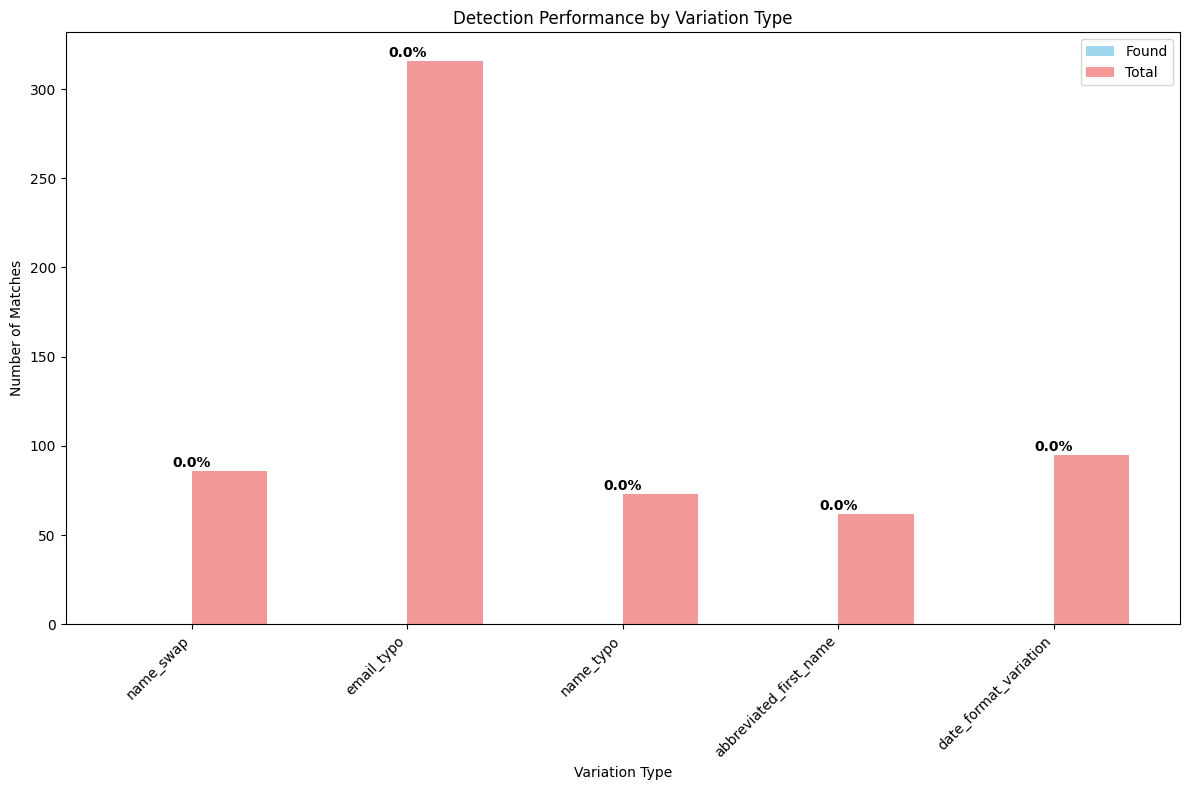

Detection Results by Variation Type:
--------------------------------------------------
name_swap                 |   0/ 86 (  0.0%)
email_typo                |   0/316 (  0.0%)
name_typo                 |   0/ 73 (  0.0%)
abbreviated_first_name    |   0/ 62 (  0.0%)
date_format_variation     |   0/ 95 (  0.0%)
--------------------------------------------------
Overall                   |   0/632 (  0.0%)


In [23]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the golden standard data
golden_standard = pd.read_csv('data/test_golden_standard_low_updated.csv')

# Replace entity types to match your test data format
golden_standard['entity_type'] = golden_standard['entity_type'].replace({
    'HealthcareOrganization': 'HealthcareOrg',
    'ServiceDepartment': 'ServiceDept'
})

# Filter for Person entities (including HealthcarePersonnel)
person_variations = golden_standard[
    (golden_standard['entity_type'] == 'Person') | 
    (golden_standard['entity_type'] == 'HealthcarePersonnel')
]

# Create a mapping from ID pairs to variation types
variation_lookup = {}
for _, row in person_variations.iterrows():
    key = (row['original_id'], row['duplicate_id'])
    variation_lookup[key] = row['variation_type']

# Convert your found results back to ID pairs
# Assuming 'found' contains tuples like ('id1', 'id2')
found_with_variation = {}

for pair in found:
    if pair in variation_lookup:
        var_type = variation_lookup[pair]
        if var_type not in found_with_variation:
            found_with_variation[var_type] = 0
        found_with_variation[var_type] += 1

# Calculate totals for each variation type
variation_totals = {}
for var_type in person_variations['variation_type'].unique():
    variation_totals[var_type] = len(person_variations[person_variations['variation_type'] == var_type])

# Prepare data for plotting
variation_types = list(variation_totals.keys())
found_counts = [found_with_variation.get(vt, 0) for vt in variation_types]
total_counts = [variation_totals[vt] for vt in variation_types]

# Create the visualization
fig, ax = plt.subplots(figsize=(12, 8))

x = range(len(variation_types))
width = 0.35

bars1 = ax.bar([i - width/2 for i in x], found_counts, width, label='Found', alpha=0.8, color='skyblue')
bars2 = ax.bar([i + width/2 for i in x], total_counts, width, label='Total', alpha=0.8, color='lightcoral')

# Add percentage labels on bars
for i, (found, total) in enumerate(zip(found_counts, total_counts)):
    percentage = (found / total * 100) if total > 0 else 0
    ax.text(i, max(found, total) + 0.5, f'{percentage:.1f}%', 
            ha='center', va='bottom', fontweight='bold')

ax.set_xlabel('Variation Type')
ax.set_ylabel('Number of Matches')
ax.set_title('Detection Performance by Variation Type')
ax.set_xticks(x)
ax.set_xticklabels(variation_types, rotation=45, ha='right')
ax.legend()

plt.tight_layout()
plt.show()

# Print detailed results
print("Detection Results by Variation Type:")
print("-" * 50)
for var_type in variation_types:
    found_count = found_with_variation.get(var_type, 0)
    total_count = variation_totals[var_type]
    percentage = (found_count / total_count * 100) if total_count > 0 else 0
    print(f"{var_type:25} | {found_count:3d}/{total_count:3d} ({percentage:5.1f}%)")

print("-" * 50)
total_found = sum(found_counts)
total_possible = sum(total_counts)
overall_percentage = (total_found / total_possible * 100) if total_possible > 0 else 0
print(f"{'Overall':25} | {total_found:3d}/{total_possible:3d} ({overall_percentage:5.1f}%)")